# Convolution and Filtering

The convolution $y[n]$ of a signal $x[n]$ with another signal $h[n]$ is defined by
\begin{align}
  y[n]= x[n] * h[n] &=  \sum_{k=-\infty}^{k=\infty} h[k] x[n-k] = \sum_{k=-\infty}^{k=\infty} x[k] h[n-k] 
\end{align}
The symbol $*$ is used as a shorthand note to describe convolution.
Note that the operation is symmetric, $x[n]$ and $h[n]$ can be swapped without changing the result. This falls directly out of the equations, and is shown in the course text-book.

This equation describes the FIR-filter operation if $h[k]=b_k$, the filter coefficients. Hence, the result from a FIR-filter is a convolution of the incoming  signal $x[n]$ with the filter coefficients $b_k$. since the impulse response $h[k]$ of a FIR-filter is equal to the filter coefficients $b_k$, it is also the convolution of the signal with its impulse response. 



In [82]:
# Interactive illustration of the convolution operation, applied to FIR filtering

# Use Matplotlib backend that allows interactive operation
%matplotlib ipympl

# from math import pi
import numpy as np
from scipy.signal import convolve

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors


class Signal():
    """Signal to be used in calculations.

    So far only simple exponential decay
    To be extended with more features

    Attributes
    ----------
    amplitude : float
        Signal amplitude
    length : int
        No. of samples in signal
    exp : float
        Exponential decay of signal
    """

    def __init__(self, amplitude=1, length=4, decay=1.0):
        self.length = length
        self.amplitude = amplitude
        self.decay = decay

    def signal(self):
        """Create signal or response."""
        return self.amplitude * self.decay**np.arange(self.length)


class ConvolutionPlot():
    """Plot all resouts of convolution."""

    def __init__(self):
        self.ax = self.initialise_graphs()
        self.color = self.initialise_colors()
        self.n = 0

    def initialise_colors(self):
        color = {}
        color["signal"] = "C0"
        color["filter"]= "C3"
        color["indicator"] = "C2"
        color["result"] = "C1"
        color["baseline"] = " " # mcolors.TABLEAU_COLORS['tab:gray']

        return color

    def initialise_graphs(self):
        """Initialise graphs for signals and spectra.

        Returns
        ------
        ax : List of axis objects
            Axes where results are plotted
        """
        
        plt.close("all")
        plt.rc('font', size=8)          # Default text sizes
        fig = plt.figure(figsize=[10, 6], 
                         constrained_layout=True, 
                         num="Convolution Demo")
                
        gs = fig.add_gridspec(3, 3)
        ax= {}
        ax["signal"] = fig.add_subplot(gs[0, 0])
        ax["filter"] = fig.add_subplot(gs[1, 0])
        ax["combined"] = fig.add_subplot(gs[0, 1:])
        ax["multiplied"] = fig.add_subplot(gs[1, 1:])
        ax["result"] = fig.add_subplot(gs[2, 1:])

        ax["signal"].set_title("Input signal", loc='left')
        ax["combined"].set_title("Signal and impulse response", loc='left')
        ax["filter"].set_title("Filter", loc='left')
        ax["multiplied"].set_title("Multiplied", loc='left')
        ax["result"].set_title("Output", loc='left')

        for k in ax:
            ax[k].set_xlabel("Sample [n]")
            ax[k].grid(True)

        return ax

    def plot_all(self, s, h, n=0):
        """Plot all signals and spectra.

        Agruments
        ---------
        s : Signal object
            Input signal
        h : Signal object
            Filter impulse response
        n : int
            Sample position to show in plot
        """

        # Calculate result of convolution
        y = convolve(s.signal(), h.signal())
        y_max = 1.2 * max(np.max(y), np.max(s.signal()), np.max(h.signal()))  # Max. y scale
        y_min = 1.2 * min(np.min(y), np.min(s.signal()), np.min(h.signal()), 0)  # Max. y scale

        # Clear old graphs
        for k in self.ax:
            for art in list(self.ax[k].lines):
                art.remove()
            for art in list(self.ax[k].collections):
                art.remove()
            for art in list(self.ax[k].patches):
                art.remove()

        # Plot input and filter response
        self.ax["signal"].stem(s.signal(), linefmt=self.color["signal"], basefmt=self.color["baseline"])
        self.ax["filter"].stem(h.signal(), linefmt=self.color["filter"], basefmt=self.color["baseline"])

        # Plot signal and flipped filter in same graph
        h_pos = n + np.arange(0, -h.length, -1)  # Shifted response
        s_pos = np.arange(s.length)
        self.ax["combined"].stem(s_pos, s.signal(), linefmt=self.color["signal"], basefmt=self.color["baseline"])
        self.ax["combined"].stem(h_pos, h.signal(), linefmt=self.color["filter"], basefmt=self.color["baseline"])

        # Plot multiplication inside filter support
        ni = n + 1 + np.arange(-h.length, 0)    # Indices overlapping with h
        ni = ni[(ni >= 0) & (ni < s.length)]
        nh = len(ni)

        h_flip = np.flip(h.signal())
        if len(ni) > 0:
            s_h = s.signal()[ni] * h_flip[0:nh]
            self.ax["multiplied"].stem(ni, s_h, linefmt=self.color["indicator"], basefmt=self.color["baseline"])

        # Plot output of convolution
        self.ax["result"].stem(y, linefmt=self.color["result"], basefmt=self.color["baseline"])

        # Show active point with indicator line
        for k in ["combined", "multiplied", "result"]:
            self.ax[k].axvline(x=n, linestyle='-', color=self.color["indicator"] )

        # Mark filter support with patch
        for k in ["combined", "multiplied"]:
            self.ax[k].add_patch(patches.Rectangle((n-h.length+1, y_min),  # (x,y)
                                 h.length-1,                            # width
                                 y_max-y_min,                           # height
                                 alpha=0.20,                            
                                 color=self.color["indicator"]))

        # Scale axes
        n_max = len(y) + 2
        for k in self.ax:
            self.ax[k].axhline(y=0, color="gray", linestyle='-')
            self.ax[k].set_ylim(y_min, y_max)
            
        for k in ["signal", "filter"]:
            self.ax[k].set_xlim(-0.5, s.length)

        for k in ["combined", "multiplied", "result"]:
            self.ax[k].set_xlim(-2, n_max)

        return 0

Label(value='FIR Filter as Convolution', style=LabelStyle(font_weight='bold'))

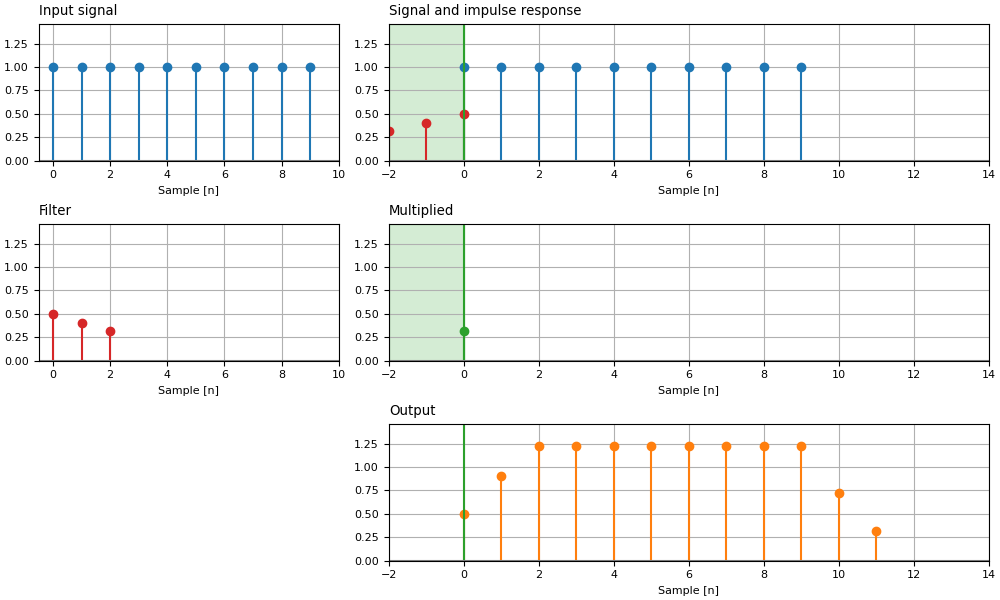

In [84]:
# Load modules for intereactive operation
import ipywidgets as widgets

#  Function that runs the demo interactively
def run_demo(indicator, 
             signal_length, signal_amplitude, signal_decay,
             filter_length, filter_amplitude, filter_decay):

    # Set values
    s.length = signal_length
    s.amplitude = signal_amplitude
    s.decay = signal_decay
    h.length = filter_length
    h.amplitude = filter_amplitude
    h.decay = filter_decay

    # Call plotting function
    cp.plot_all(s, h, indicator)
    return

# Define widgets
w_layout = widgets.Layout(width='80%')
widget_style = {'description_width': 'initial'}

title_widget = widgets.Label("FIR Filter as Convolution", style=dict(font_weight='bold'))

label = ["Signal", "Filter"]
label_widget = [widgets.Label(labeltext,
                              layout=widgets.Layout(width='7%'), 
                              style=widget_style) 
                for labeltext in label]

length = [10, 3]
length_widget = [widgets.IntText(min=1, max=20, value=n, 
                                 description="Length", 
                                 layout=widgets.Layout(width='10%'), 
                                 style=widget_style)
                 for n in length]

amplitude = [1.0, 0.5]
amplitude_widget = [widgets.FloatText(min=0.1, max=2.0, step=0.1, value=k, 
                                      description="Amplitude", 
                                      layout=widgets.Layout(width='10%'), 
                                      style=widget_style)
                    for k in amplitude]

decay = [1.0, 0.8]
decay_widget = [widgets.FloatText(min=0.1, max=1.0, step=0.1, value=k, 
                                  description="Decay", 
                                  layout=widgets.Layout(width='10%'), 
                                  style=widget_style)
                for k in decay]

# Create lines of parameter widgets 
widget_line = [widgets.HBox([label_widget[k], length_widget[k], amplitude_widget[k], decay_widget[k]]) for k in range(2)]

# Add slider for position indicator
indicator_widget = widgets.IntSlider(min= -1, max= 20.0, value= 0, description='Indicator', layout=widgets.Layout(width='70%'))

widget_grid = widgets.VBox([grid_line for grid_line in widget_line] )
widget_grid = widgets.VBox([widget_grid, indicator_widget])

display(title_widget)
display(widget_grid)

# Initialise signal
cp= ConvolutionPlot()
s = Signal()
h = Signal()

# Call display function interactively
w = widgets.interactive(run_demo, indicator=indicator_widget, 
                        signal_length=length_widget[0], signal_amplitude=amplitude_widget[0], signal_decay=decay_widget[0],
                        filter_length=length_widget[1], filter_amplitude=amplitude_widget[1], filter_decay=decay_widget[1])
